# Data ingestion notebook

This notebook includes scripts to download point-of-interest data from various sources. It can be ran manually and piece-by-piece to refresh the data sources as necessary.

## Data sought

We want a range of different data sources representing different locations of interest. Pulling these from the Google Places API is expensive, so we'll use free sources where possible.

We want to obtain the locations of the following:

- Cafes
- Restaurants
- Bars/Pubs
- Grocery stores
- Pharmacies
- Child care
- Aged care
- Hospitals
- Schools and universities
- Libraries
- Museums
- Galleries
- Parks
- Post offices
- Places of worship

We also want to combine this with census data at the LGA, POA, and suburb levels.

## Area of interest

We are focused on the general Melbourne urban area, represented by these LGAs:

- Banyule
- Bayside (Vic.)
- Boroondara
- Brimbank
- Darebin
- Glen Eira
- Greater Dandenong
- Hobsons Bay
- Hume
- Kingston (Vic.)
- Knox
- Manningham
- Maribyrnong
- Maroondah
- Melbourne
- Melton
- Monash
- Moonee Valley
- Moreland
- Nillumbik
- Port Phillip
- Stonnington
- Whitehorse
- Whittlesea
- Wyndham
- Yarra

This correlates roughly to a bounding box of:

```
N: -37.4
S: -38.1
E: 145.4
W: 144.4
```

In overlaying datasources we preference the GDA2020 projection over WGS84, but will convert as necessary.


## Data sources

### Vicmap Features - Features of Interest (FOI) Point

[Link](https://datashare.maps.vic.gov.au/search?md=019d7631-1234-5112-9f21-8f7346647b61)

Coverage:

- Places of worship
- Child care
- Aged care
- Hospitals
- Schools and universities
- Libraries
- Museums
- Galleries
- Parks

Free, provided as shapefile download. 

### Here Geocoding and Search API (`browse` endpoint)

[Link](https://www.here.com/docs/bundle/geocoding-and-search-api-v7-api-reference/page/index.html#/paths/~1browse/get)

Coverage:
- Cafes
- Restaurants
- Bars/Pubs
- Grocery Stores

Paid after 5,000 requests per month. REST API.

### Australia Post API

[Link](https://auspost.com.au/developers/openapi/public/locations/operation/getGeoLocationsByPostCodeUsingGET/)

Can query all post points by post code area or distance from a co-ordinate pair.

Coverage:
- Post offices

Free with API key

### Pharmacy Guild

[Link](https://www.findapharmacy.com.au/)

The Find a Pharmacy website queries an unsecured API backend to populate its map, which we can intercept for our own purposes.

Coverage:
- Pharmacies

Free

### Census 2021 datapacks

[Link](https://www.abs.gov.au/census/find-census-data/datapacks)

Provides direct data for given geographies in CSV. 

### Census geographies

[Link](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files)

Shapefiles for 2021 geographies (in GDA2020).

## Credentials
Refer to the `env.template` file and save as `.env` with credentials attached.

## Processing aims

Location data should be combined into a unified labelling schema in GDA2020, importable to a single geopandas geodataframe with point geometries. Labelling should indicate source and location type, i.e. each location should have:

- GDA2020 point geometry
- Name
- Category
- Source

Data is saved in `data/prepared/` as feather for downstream processing.



## Imports and set up

In [51]:
import geopandas as gpd
from shapely.geometry import Polygon
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from shapely.geometry import box
import numpy as np

# get credentials

load_dotenv()
keys={
    'here': os.getenv('HERE_API_KEY'),
    'auspost': os.getenv('AUSPOST_API_KEY')
}


## Shapefile processing

Shapefiles downloaded from the ABS can be quite heavy, we'll pare them down for production.

In [64]:
# bounding box for filtering
n, s, e, w = -37.4, -38.1, 145.4, 144.4

bbox_polygon = Polygon([(w, n), (e, n), (e, s), (w, s), (w, n)])
bb_gdf = gpd.GeoDataFrame(index=[0], geometry=[bbox_polygon], crs="EPSG:7844") # GDA2020's EPSG code is 7844

bb_gdf.to_file("data/meta/area_of_interest_bounding_box.shp")

In [65]:
def read_shp(geography, year = 2021):
    filestr =f'data/shapefiles/{geography}_{year}_AUST_GDA2020_SHP/{geography}_{year}_AUST_GDA2020.shp'
    return gpd.read_file(filestr)

lga_shp = read_shp('LGA')
poa_shp = read_shp('POA')
sal_shp = read_shp('SAL')

print(len(lga_shp))

lga_shp.head()

566


,LGA_CODE21,LGA_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
0,10050,Albury,1,New South Wales,AUS,Australia,305.6386,http://linked.data.gov.au/dataset/asgsed3/LGA2...,1.321768,0.030560,"POLYGON ((146.86566 -36.07292, 146.86512 -36.0..."
1,10180,Armidale Regional,1,New South Wales,AUS,Australia,7809.4406,http://linked.data.gov.au/dataset/asgsed3/LGA2...,6.034583,0.732825,"POLYGON ((151.32425 -30.26922, 151.32419 -30.2..."
2,10250,Ballina,1,New South Wales,AUS,Australia,484.9692,http://linked.data.gov.au/dataset/asgsed3/LGA2...,1.511121,0.044843,"MULTIPOLYGON (((153.57106 -28.87381, 153.57106..."
3,10300,Balranald,1,New South Wales,AUS,Australia,21690.7493,http://linked.data.gov.au/dataset/asgsed3/LGA2...,11.489912,2.115528,"POLYGON ((143.00433 -33.78164, 143.01538 -33.7..."
4,10470,Bathurst Regional,1,New South Wales,AUS,Australia,3817.8645,http://linked.data.gov.au/dataset/asgsed3/LGA2...,5.395114,0.370149,"POLYGON ((149.91213 -33.39581, 149.91147 -33.3..."


<Axes: >

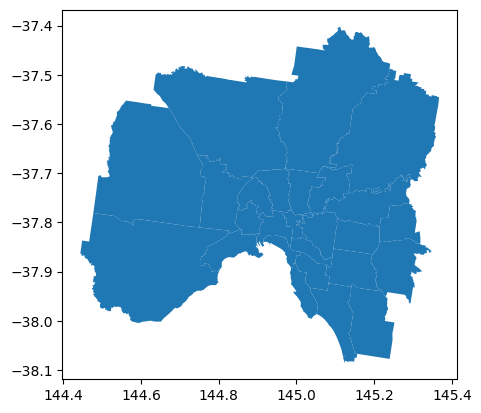

In [66]:
# use the bounding box to trim off extraneous shapes

lga_gdf = lga_shp[lga_shp.geometry.within(bb_gdf.geometry[0])]

lga_area_of_interest = lga_gdf.unary_union

lga_gdf.plot()

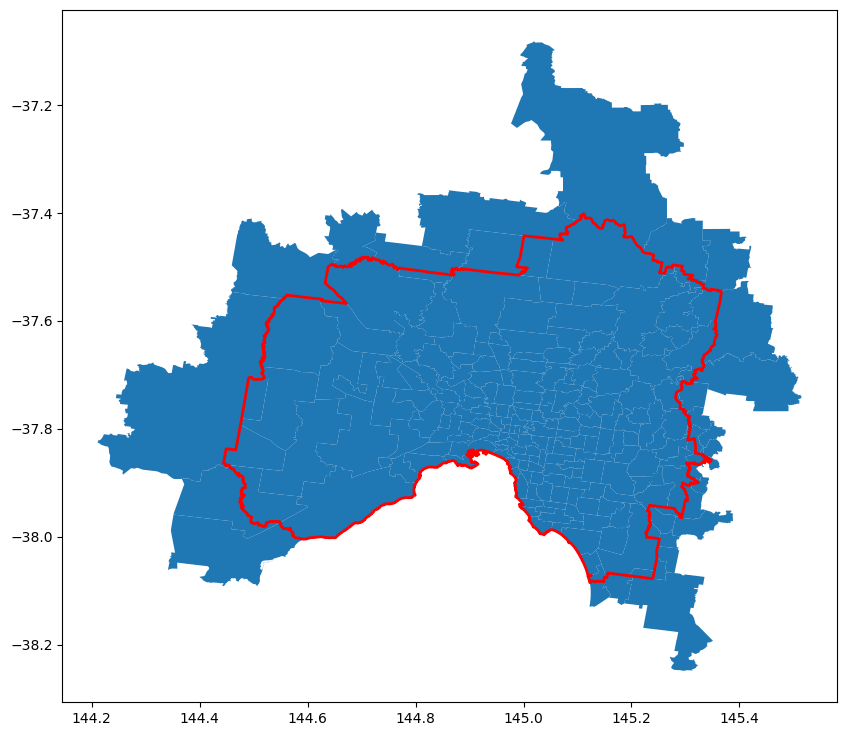

In [67]:
# For POA and SAL geographies, we're happy to take the intersection

sal_gdf = sal_shp[sal_shp.geometry.intersects(lga_area_of_interest)]
poa_gdf = poa_shp[poa_shp.geometry.intersects(lga_area_of_interest)]

ax = poa_gdf.plot(figsize=(10, 10))
gpd.GeoSeries([lga_area_of_interest]).plot(ax=ax, color='none', edgecolor='red', linewidth=2)

plt.show()

There are 4051 cells in total with a 1km resolution


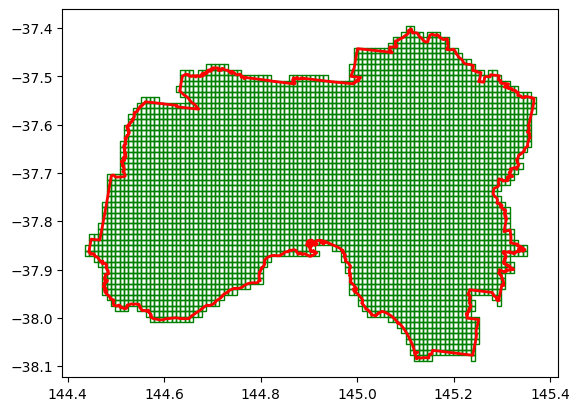

In [119]:

def km_to_deg(km, lat):
    """Converts kilometers to degrees at a specified latitude."""
    km_per_degree_latitude = 111.32
    km_per_degree_longitude = 111.32 * np.cos(np.radians(lat))
    return km / km_per_degree_latitude, km / km_per_degree_longitude

def generate_tiled_gdf(bounding_box, resolution, crs="EPSG:7844"):
    minx, miny, maxx, maxy = bounding_box.bounds
    width_deg, height_deg = km_to_deg(resolution, (miny + maxy) / 2)
    
    rows = int(np.ceil((maxy - miny) / height_deg))
    cols = int(np.ceil((maxx - minx) / width_deg))
    
    squares = []
    for i in range(rows):
        for j in range(cols):
            bot_left_lat = miny + i * height_deg
            bot_left_lon = minx + j * width_deg
            square = box(bot_left_lon, bot_left_lat, 
                         bot_left_lon + width_deg, bot_left_lat + height_deg)
            squares.append(square)
    
    return gpd.GeoDataFrame(geometry=squares, crs=crs)

resolution_km = 1

grid_gdf = generate_tiled_gdf(bb_gdf.unary_union, resolution_km)
grid_samples_gdf = grid_gdf[grid_gdf.geometry.intersects(lga_area_of_interest)]

ax = grid_samples_gdf.plot(color='none', edgecolor='green', linewidth=1)
gpd.GeoSeries([lga_area_of_interest]).plot(ax=ax, color='none', edgecolor='red', linewidth=2)

print(f'There are {len(grid_samples_gdf)} cells in total with a {resolution_km}km resolution')

In [122]:
# save gdf objects to feather

lga_gdf[['LGA_CODE21','LGA_NAME21','AREASQKM21','geometry']].to_feather('data/prepared/lga.feather')
poa_gdf[['POA_CODE21','POA_NAME21','AREASQKM21','geometry']].to_feather('data/prepared/poa.feather')
sal_gdf[['SAL_CODE21','SAL_NAME21','AREASQKM21','geometry']].to_feather('data/prepared/sal.feather')
grid_gdf.to_feather(f'data/prepared/{resolution_km}kmgrid.feather')


## Vicmap processing

Export and download the latest shapefile for the above co-ordinates in the GDA2020 projection. Use the area of interest bounding box shapefiles to filter down the export required. Copy the contents of `user_polygon-0` to the `data` folder as `vicmap-foi`.

In [29]:
vicmap_gdf = gpd.read_file('data/vicmap-foi/VMFEAT/FOI_POINT.shp')

# processing:
# - filter desired fields
# - map to desired columns (multipoint -> point geometries)

vicmap_labels = [
    'child care','aged care','entertainment centre','hall','community centre','senior citizens','art gallery','museum','library',
    'primary/secondary school','special school','primary school','tertiary institution','secondary school','university',
    'police station','ambulance station','fire station','maternal/child health centre','general hospital','day procedure centre',
    'tower','monument','tourist attraction','church','mosque','synagogue','rotunda','day visitor area','club house',
    'picnic site','playground','swimming pool'
]

cleaned_vicmap_gdf = (
    vicmap_gdf
    [vicmap_gdf['FEATSUBTYP'].isin(vicmap_labels)]
    [['FEATSUBTYP','NAME_LABEL','geometry']]
    .rename(columns = {'FEATSUBTYP': 'category', 'NAME_LABEL': 'name'})
)

def convert_multi_to_pt(geom):
    return geom.geoms[0] if geom.geom_type == 'MultiPoint' else geom

cleaned_vicmap_gdf['geometry'] = cleaned_vicmap_gdf['geometry'].apply(convert_multi_to_pt)

cleaned_vicmap_gdf.to_feather('data/prepared/vicmap.feather')

cleaned_vicmap_gdf.head(5)


,category,name,geometry
0,secondary school,Elisabeth Murdoch College,POINT (145.19019 -38.15928)
1,primary school,Frankston Heights Primary School,POINT (145.14718 -38.16179)
2,secondary school,Koo Wee Rup Secondary College,POINT (145.49578 -38.19708)
3,primary school,St Augustines School,POINT (145.14588 -38.17203)
4,special school,Mount Erin Secondary College - Mount Erin Deaf...,POINT (145.14623 -38.17396)


In [27]:
# location counts
cleaned_vicmap_gdf[['category','geometry']].groupby('category').count()

,geometry
category,
aged care,512
ambulance station,97
art gallery,31
child care,3523
church,602
club house,448
community centre,228
day procedure centre,95
day visitor area,64


## Here API processing

In [125]:
## 





In [ ]:
##

## Australia Post API processing

## Pharmacy Guild processing

## Census processing